# Evaluation Metrics for Classification

In the previous session we trained a model for predicting churn. How do we know if it's good?


- Kaggle: https://www.kaggle.com/blastchar/telco-customer-churn
- Dataset: https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv


[*Metric*](https://developers.google.com/machine-learning/crash-course/classification/accuracy-precision-recall) - function that compares the predictions with the actual values and outputs a single number that tells how good the predictions are

## Training the Classification Model

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [3]:
url = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv'
df = pd.read_csv(url)

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [4]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [5]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [6]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

/opt/miniconda3/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [7]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)

## Thresholds

In a binary classification, a number between 0 and 1 that converts the raw output of a logistic regression model into a prediction of either the positive class or the negative class. Note that the classification threshold is a value that a human chooses, not a value chosen by model training.

A logistic regression model outputs a raw value between 0 and 1. Then:

- If this raw value is greater than the classification threshold, then the positive class is predicted.
- If this raw value is less than the classification threshold, then the negative class is predicted.

For example, suppose the classification threshold is 0.8. If the raw value is 0.9, then the model predicts the positive class. If the raw value is 0.7, then the model predicts the negative class.

The choice of classification threshold strongly influences the number of false positives and false negatives.


## Accuracy

Accuracy is the proportion of all classifications that were correct, whether positive or negative. It is mathematically defined as:

![accuracy](./img/image1.png)

In the churn classification example, accuracy measures the fraction of all customer churn correctly classified. A perfect model would have zero false positives and zero false negatives and therefore an accuracy of 1.0, or 100%.

- TP -> True Positive
- TN -> True Negative
- FP -> False Positive
- FN -> False Negative

Because it incorporates all four outcomes from the confusion matrix (TP, FP, TN, FN), given a balanced dataset, with similar numbers of examples in both classes, accuracy can serve as a coarse-grained measure of model quality. For this reason, it is often the default evaluation metric used for generic or unspecified models carrying out generic or unspecified tasks.

However, when the dataset is imbalanced, or where one kind of mistake (FN or FP) is more costly than the other, which is the case in most real-world applications, it's better to optimize for one of the other metrics instead.

For heavily imbalanced datasets, where one class appears very rarely, say 1% of the time, a model that predicts negative 100% of the time would score 99% on accuracy, despite being useless.



In [8]:
# Accuracy = TP + TN / Total
(y_val == churn_decision).mean()

0.8026969481902059

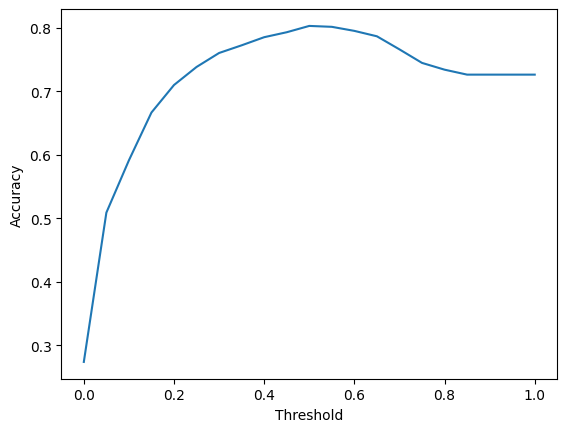

In [12]:
threshold = np.linspace(0, 1, 21)
accuracy = []

for t in threshold:
    churn_decision = (y_pred >= t)
    # acc = (y_val == churn_decision).mean()
    acc = accuracy_score(y_val, churn_decision)
    accuracy.append(acc)

plt.plot(threshold, accuracy)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.show()

In [13]:
# Check for class imbalance in churn rate
df.churn.value_counts(normalize=True)

churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64